#### Beamforming implementation by FK analysis
Author: Anmol Harshana   Date: 27/11/2021

The following code borrows heavily from: https://docs.obspy.org/tutorial/code_snippets/beamforming_fk_analysis.html

The details for data generation:

vert_force3D.ipynb: file used for data generation. 

Receiver positions: (x,y: randomized), z: 0 (on the surface)

Number of receivers = 101

Only z -axis data for the receivers will be utilized.

Source position: at (500,500,0). Note that in this case the z axis points downwards. 

The total time for recorded data: 1s.

Number of Samples = 810

Start and End time will be used as given default by ObsPy library. 

First step is to convert the receiver data into a a stream object and store it in a file in .mseed format for future reference. Then next step is to use the array processing function along with a polat plot visualization to get a sense of the direction of the source. 

In [1]:
# importing required libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize

import numpy as np
import obspy
from obspy.core.util import AttribDict
from obspy.imaging.cm import obspy_sequential
from obspy.signal.array_analysis import array_processing
from obspy.core.trace import Trace
from obspy.core.stream import Stream

In [2]:
## Loading the data from data files 
z_data = np.genfromtxt('recz_data.csv',delimiter=',')   # data recorded in z direction
z_data[0] = 10000*z_data[0]
rec_x_pos = np.genfromtxt('recx_pos.csv',delimiter=',') # x coordinate of receiver position
rec_y_pos = np.genfromtxt('recy_pos.csv',delimiter=',') # y coordinate of receiver position

In [3]:
# Now storing this data with proper format in a .mseed file
st =Stream()
for i in range(101):
    stats = {'network': 'SATLAB', 'station': 'GLEE', 'location':str(rec_x_pos[i])+','+str(rec_y_pos[i]) ,
             'coordsys': 'xy','coordinates':AttribDict({'x': rec_x_pos[i],'y': rec_y_pos[i],'elevation': 0}),
         'channel': 'WLZ', 'npts': len(z_data[0]), 'sampling_rate': 810,
         'mseed': {'dataquality': 'D'}} # stats for receivers
    tr =Trace(data=z_data[0], header=stats)   # creating a trace for 1 receiver
    st.append(tr)
    
st.write('Exp_1.mseed') # storing data in .mseed file for later purposes

In [4]:
# Now checking the stats of one of the traces

st[0].stats

         network: SATLAB
         station: GLEE
        location: 773.0,205.0
         channel: WLZ
       starttime: 1970-01-01T00:00:00.000000Z
         endtime: 1970-01-01T00:00:00.998765Z
   sampling_rate: 810.0
           delta: 0.0012345679012345679
            npts: 810
           calib: 1.0
     coordinates: AttribDict({'x': 773.0, 'y': 205.0, 'elevation': 0})
        coordsys: xy
           mseed: AttribDict({'dataquality': 'D'})

Now we have a proper seismic object for processing. Now  implementing beamforming.

In [11]:
kwargs = dict(
    # slowness grid: X min, X max, Y min, Y max, Slow Step
    sll_x=-0.5, slm_x=0.5, sll_y=-0.5, slm_y=0.5, sl_s=0.5,coordsys='xy',
    # sliding window properties
    win_len=0.10, win_frac=0.05,
    # frequency properties
    frqlow=1.0, frqhigh=20.0, prewhiten=0,
    # restrict output
    semb_thres=-1e9, vel_thres=-1e9,
    stime=obspy.UTCDateTime("19700101000000"),
    etime=obspy.UTCDateTime("19700101000000.99876")
)   # arguments for array processing
out = array_processing(st, **kwargs)

In [12]:
# Separately storing time, rel_power,abs_power, backazimuth and slowness

t, rel_power, abs_power, baz, slow = out.T
baz[baz < 0.0] += 360   


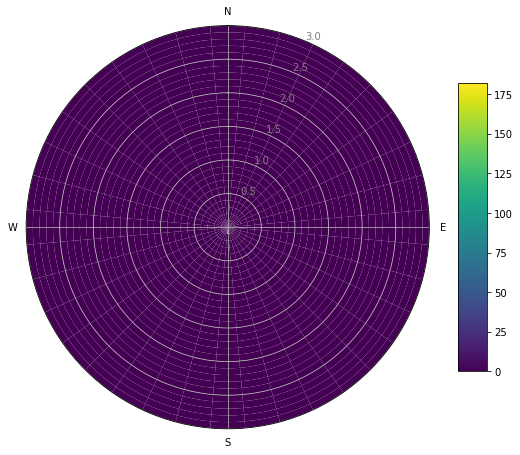

In [13]:
# choose number of fractions in plot (desirably 360 degree/N is an integer!)
N = 36
N2 = 30
abins = np.arange(N + 1) * 360. / N
sbins = np.linspace(0, 3, N2 + 1)
cmap = obspy_sequential

# sum rel power in bins given by abins and sbins
hist, baz_edges, sl_edges = \
    np.histogram2d(baz, slow, bins=[abins, sbins], weights=rel_power)

# transform to radian
baz_edges = np.radians(baz_edges)

# add polar and colorbar axes
fig = plt.figure(figsize=(8, 8))
cax = fig.add_axes([0.85, 0.2, 0.05, 0.5])
ax = fig.add_axes([0.10, 0.1, 0.70, 0.7], polar=True)
ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")

dh = abs(sl_edges[1] - sl_edges[0])
dw = abs(baz_edges[1] - baz_edges[0])

# circle through backazimuth
for i, row in enumerate(hist):
    bars = ax.bar((i * dw) * np.ones(N2),height=dh * np.ones(N2),width=dw, bottom=dh * np.arange(N2),color=cmap(row / hist.max()))

ax.set_xticks(np.linspace(0, 2 * np.pi, 4, endpoint=False))
ax.set_xticklabels(['N', 'E', 'S', 'W'])

# set slowness limits
ax.set_ylim(0, 3)
[i.set_color('grey') for i in ax.get_yticklabels()]
ColorbarBase(cax, cmap=cmap,
             norm=Normalize(vmin=hist.min(), vmax=hist.max()))

plt.show()

array([  1.00000000e-08])

array([ 180.,  180.,  180.,  180.,  180.,  180.,  180.,  180.,  180.,
        180.,  180.,  180.,  180.,  180.,  180.,  180.,  180.,  180.,
        180.,  180.,  180.,  180.,  180.,  180.,  180.,  180.,  180.,
        180.,  180.,  180.,  180.,  180.,  180.,  180.,  180.,  180.,
        180.,  180.,  180.,  180.,  180.,  180.,  180.,  180.,  180.,
        180.,  180.,  180.,  180.,  180.,  180.,  180.,  180.,  180.,
        180.,  180.,  180.,  180.,  180.,  180.,  180.,  180.,  180.,
        180.,  180.,  180.,  180.,  180.,  180.,  180.,  180.,  180.,
        180.,  180.,  180.,  180.,  180.,  180.,  180.,  180.,  180.,
        180.,  180.,  180.,  180.,  180.,  180.,  180.,  180.,  180.,
        180.,  180.,  180.,  180.,  180.,  180.,  180.,  180.,  180.,
        180.,  180.,  180.,  180.,  180.,  180.,  180.,  180.,  180.,
        180.,  180.,  180.,  180.,  180.,  180.,  180.,  180.,  180.,
        180.,  180.,  180.,  180.,  180.,  180.,  180.,  180.,  180.,
        180.,  180.,